## Results of point pollution surface oil spill scenarios at Active Pass
Tug towing a fuel barge misjudges the tides in Active Pass and barge gets pushed on the rocks puncturing one of its fuel tanks, spilling 500 m<sup>-3</sup> of marine diesel. Scenario is built on ROC report 869, 2019.

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = [60, 62, 63]

In [3]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Define scenario and control files

In [4]:
hex_colour = '#863092'
hatches = ['oo', '///', 'xx', '++']

In [5]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/ForcingFiles/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_4a*_10000_fromzarr.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [6]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL-fishing/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
#control_mean = xr.open_dataset(str(control_file), decode_cf=True).resample(t='1Y').mean()
time = np.ma.filled(control.variables['t'])
#time_mean = np.ma.filled(control_mean.variables['t'])

In [7]:
scenario_paths = sorted([p for p in scenario_root.glob('Scenario_4a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

Scenario_4a_1_2019-07-04 low Fraser flow spring tide summer
Scenario_4a_2_2019-07-10 low Fraser flow neap tide summer
Scenario_4a_3_2020-07-22 high Fraser flow spring tide summer
Scenario_4a_4_2020-07-12 high Fraser flow neap tide summer


In [8]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
#scenario_mean_datasets = [xr.open_dataset(scen,decode_cf=True).resample(t='1Y').mean() for scen in scenario_paths]
#time_mean = np.ma.filled(control_mean.variables['t'])

In [9]:
# start and end time of data display, after burn-in
start = 100
end = time.size-1

### Mapping spill extent

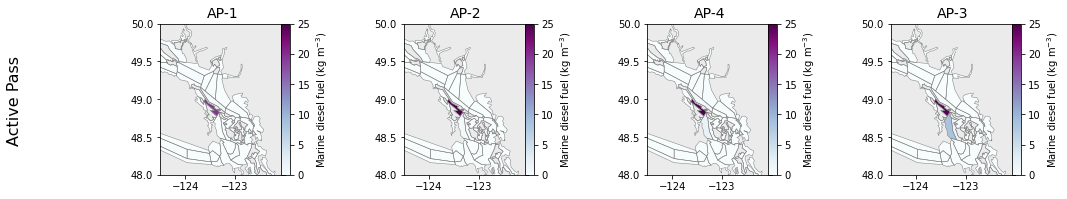

In [12]:
fig = plt.figure(figsize=(16, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

position = 0

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'AP-'+ str(groups.simulations[groups.conditions[date]])
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)
    #print(oil_b.max())

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    #oil_df = data_df.loc[data_df['oil'] > 0]

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB') ##C0C0C0
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax, cmap=cm.BuPu, vmax=25, 
    legend_kwds={'label': 'Marine diesel fuel (kg m$^{-3}$)'}, legend=True, 
    )
    ax.set_title(label, fontsize = 14) #loc='left'
    ax.set_xlim(-124.5)
    ax.set_ylim(48, 50)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
    position = position+1
fig.supylabel('Active Pass', fontsize = 16); #color=hex_colour

### Oil injection

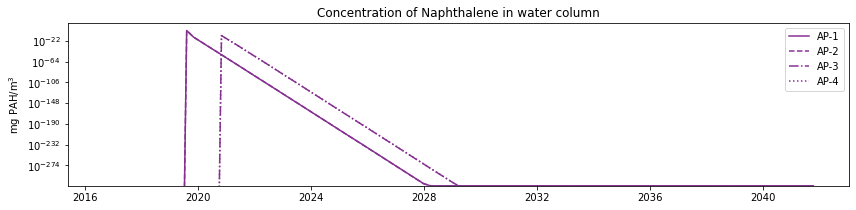

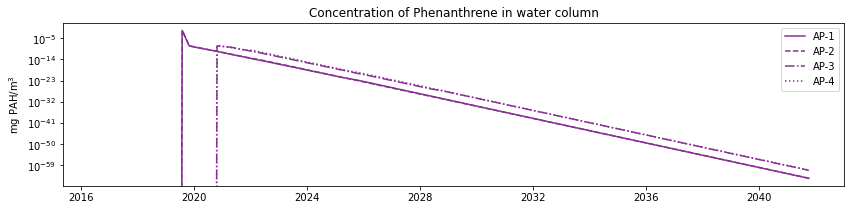

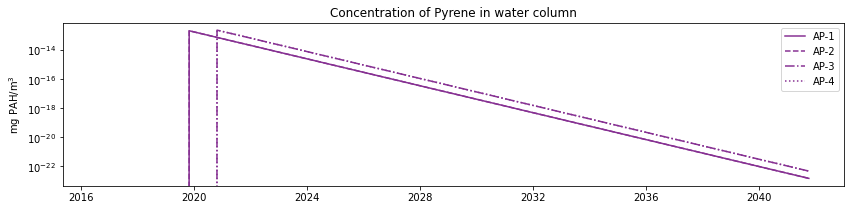

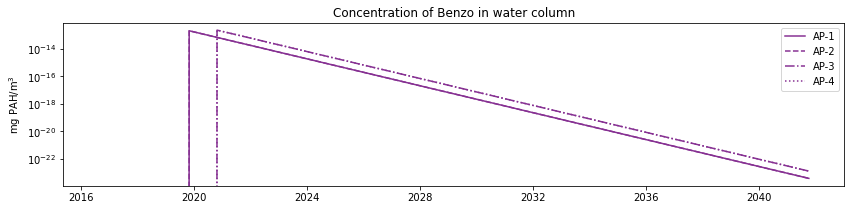

In [13]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem.split(sep = '_')
      names.append('AP-'+str(nm[2]))
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

## Results
### Time-separate box plots

In [14]:
print('closest time points to 2019 spill: ' + str(time[116]))
print('5 years post spill: ' + str((time[132])))
print('10 years post spill: ' + str(time[152]))
print('20 years post spill: ' + str(time[193]))
print('end of the run: '+ str(time[end]))

closest time points to 2019 spill: 2020-07-31T14:00:00.000000000
5 years post spill: 2024-07-10T14:00:00.000000000
10 years post spill: 2029-06-14T14:00:00.000000000
20 years post spill: 2039-07-22T14:00:00.000000000
end of the run: 2041-12-18T14:00:00.000000000


In [15]:
print('closest time points to 2020 spill: ' + str(time[120]))
print('5 years post spill: ' + str((time[136])))
print('10 years post spill: ' + str(time[156]))
print('20 years post spill: ' + str(time[197]))

closest time points to 2020 spill: 2021-07-26T14:00:00.000000000
5 years post spill: 2025-07-05T14:00:00.000000000
10 years post spill: 2030-06-09T14:00:00.000000000
20 years post spill: 2040-07-16T14:00:00.000000000


In [16]:
days2019summer = [116, 132, 152, 193]
days2020summer = [120, 136, 156, 197]

In [29]:
def progressive_boxplot_plankton(location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']
    names = ['Phytoplankton','Zooplankton']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        results = []
        for day in end_days: 
            p_oiled = 0
            p_control = 0
            for species in groups.phytoplankton: 
                p_oiled = p_oiled + np.ma.filled(scenario.variables[groups.phytoplankton[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = p_control + np.ma.filled(control.variables[groups.phytoplankton[species] + '_N'][start:day, location, 0:6], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            p_ratio = (p_oiled / p_control - 1) * 100
            results.append(p_ratio)

            z_oiled = 0
            z_control = 0
            for species in groups.zooplankton:
                z_oiled = z_oiled + np.ma.filled(scenario.variables[groups.zooplankton[species] + '_N'][start:day, location, 0:6], np.nan)
                z_control = z_control + np.ma.filled(control.variables[groups.zooplankton[species] + '_N'][start:day, location, 0:6], np.nan)
                
            z_oiled_total = z_oiled.sum(axis=(1, 2)).mean()
            z_control_total = z_control.sum(axis=(1, 2)).mean()
            z_ratio = (z_oiled_total / z_control_total - 1) * 100
            results.append(z_ratio)
            
        for name in names:
            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': name,
                    'sensitivity': groups.sensitivity[name],
                    'sensitivity_negative': -groups.sensitivity[name],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-plankton.csv")
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
         n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', alpha=0.5, hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    plt.show()

In [19]:
def progressive_boxplot_pelagic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location, 0:6], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1, 2)).mean()
                p_control = p_control.sum(axis=(1, 2)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/4a-active-pass-"+str(bio_group[species])+".csv")
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    if n_rows < 7:
        n_rows = 7
    elif n_rows >10:
        n_rows = 15
    else:
         n_rows = n_rows
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios)  
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', alpha=0.5, hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    plt.show()

In [96]:
def progressive_boxplot_benthic(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            for day in end_days:
                p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:day, location], np.nan)
                
                p_oiled = p_oiled.sum(axis=(1)).mean()
                p_control = p_control.sum(axis=(1)).mean()
                
                ratio = (p_oiled / p_control - 1) * 100
                results.append(ratio)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
   #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/affected-boxes-4a-active-pass-benthos.csv")
   
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  

    bar_width = 0.8 / len(scenarios) 
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, edgecolor='black', alpha=0.5, hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
        
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    plt.show()

In [21]:
def progressive_boxplot_vertebrates(bio_group, location=groups.salish_sea, x_lim=None):
    all_results = []
    data_labels = ['spill year', '5 years later', '10 years later', '20 years later']

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        year = str(nm[3]).split(sep='-')[0]
        scenario_name = 'AP-'+nm[2]  # Readable scenario name

        if year == '2019':
            end_days = days2019summer
        elif year == '2020':
            end_days = days2020summer

        for species in bio_group:
            results = []
            numCohorts = groups.cohorts[bio_group[species]]
            for day in end_days:

                sum_ratio = 0

                for cohort in range (1, numCohorts+1):

                    new_species = bio_group[species] + str(cohort)
                
                    o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][start:day, location, 0:6], np.nan)
                    c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][start:day, location, 0:6], np.nan)
                    c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][start:day, location, 0:6], np.nan)

                    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                    o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                    c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                    #difference = o_weightatage_tb.sum(axis=1) - c_weightatage_tb.sum(axis=1) 
                    ratio = (o_weightatage / c_weightatage - 1) * 100
                    #print(ratio)
                    sum_ratio = sum_ratio + ratio

                results.append(sum_ratio/numCohorts)

            for label, value in zip(data_labels, results):
                all_results.append({
                    'bio_group': bio_group[species],
                    'sensitivity': groups.sensitivity[species],
                    'sensitivity_negative': -groups.sensitivity[species],
                    'time_label': label,
                    'scenario': scenario_name,
                    'percent_change': value
                })

    df = pd.DataFrame(all_results)
    #df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/6a-english-bay-"+str(bio_group[species])+".csv")
    #print(df)
    
    time_labels = df['time_label'].unique()
    bio_groups = df['bio_group'].unique()
    scenarios = df['scenario'].unique()
    colors = plt.cm.tab10.colors

    n_rows = len(bio_groups)
    n_cols = len(time_labels)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, n_rows+1), sharey=True)

    if n_cols == 1:
        axes = [axes]  # Make iterable if only 1 subplot

    bar_width = 0.8 / len(scenarios)  # space per group divided by number of scenarios
    y_pos = np.arange(len(bio_groups))

    for i, time in enumerate(time_labels):
        ax = axes[i]
        for j, scenario in enumerate(scenarios):
            df_plot = df[(df['time_label'] == time) & (df['scenario'] == scenario)]
            df_plot = df_plot.set_index('bio_group').reindex(bio_groups)  # Ensure consistent order
            offset = (j - len(scenarios)/2) * bar_width + bar_width/2

            ax.barh(y_pos + offset, df_plot['percent_change'], height=bar_width, label=scenario, facecolor=hex_colour, alpha=0.6, edgecolor='black', hatch=hatches[j])
        ax.barh(bio_groups, df_plot['sensitivity'], label=scenario, color='grey', alpha=0.3)
        ax.barh(bio_groups, df_plot['sensitivity_negative'], label=scenario, color='grey', alpha=0.3)
       
        ax.set_title(time, fontsize=15)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bio_groups, fontsize=15) 
        ax.set_xlim(x_lim)
        ax.set_xlabel("Percent Change", fontsize=13)

    fig.legend(np.append(scenarios,'model threshold'), loc='upper center', ncol=len(scenarios)+1, fontsize=15) 
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #axes[0].set_ylabel(bio_groups)
    plt.show()

In [53]:
affected_pelagic = { # greater than a 5% change across the entire model, plus any change above threshold for mammals
    'porpoises':'Harbor_porpoise', 'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient', 'Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'small pelagic':'Small_pelagic_fish',
}

affected_benthos = {'macrobenthos':'Macrobenthos',  
    'sponges':'Sponges', 'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
    'macroalgae':'Macroalgae', 'seagrass':'Seagrass', 
}

plankton = { 
    'picophytoplankton':'PicoPhytopl', 'diatoms':'Diatom', 
    'microzooplankton':'MicroZoo','mesozooplankton':'Zoo', 'squid':'Squid', 
}

fish = {'benthopelagic':'Benthopelagic', 'small pelagic':'Small_pelagic_fish', 'small demersal':'Small_Demersal_fish', 
    'lingcod':'Lingcod', 'sandlance':'Sandlance', 'pacific herring':'Pacific_herring',
    'Chum':'Chum_salmon', 'Coho':'Coho_salmon','Pink':'Pink_salmon',
    'Hatchery Chinook':'Hatchery_Chinook_salmon','Hatchery Coho':'Hatchery_Coho_salmon','Hatchery Sockeye':'Hatchery_Sockeye_salmon',
    'Other salmonids':'Other_salmonids',  'dogfish':'Dogfish',
}
mammals = {
    'porpoises':'Harbor_porpoise', 'seals':'Harbor_seals', 'humpbacks':'Humpback_whales',
    'resident orcas':'Orcas_resident', 'transient orcas':'Orcas_transient',
}

shellfish = { #benthic, 1 depth
    'bivalves':'Bivalves', 'crabs':'Crabs', 'dungeness crabs':'Dungeness_crabs',
}



### Affected groups

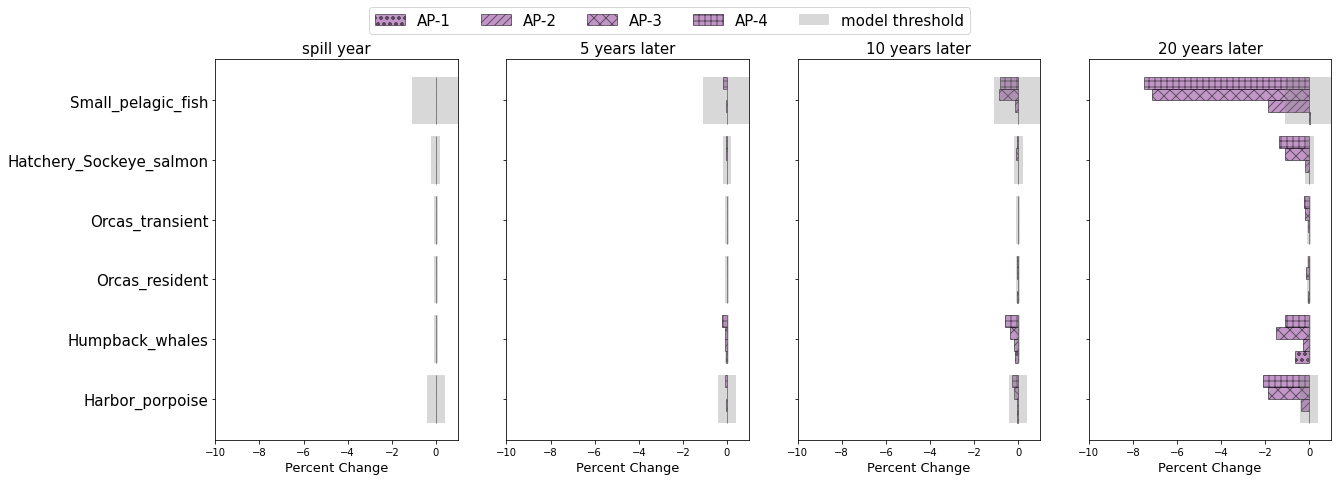

In [54]:
progressive_boxplot_pelagic(affected_pelagic, x_lim=[-10, 1])

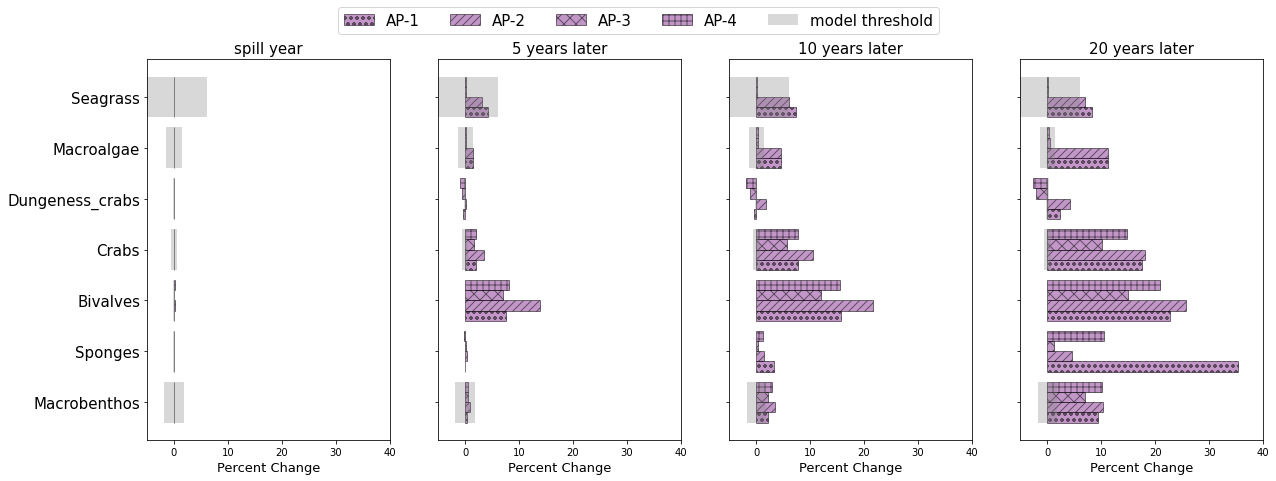

In [41]:
progressive_boxplot_benthic(affected_benthos, location=affected_boxes, x_lim=[-5, 40])

### All groups

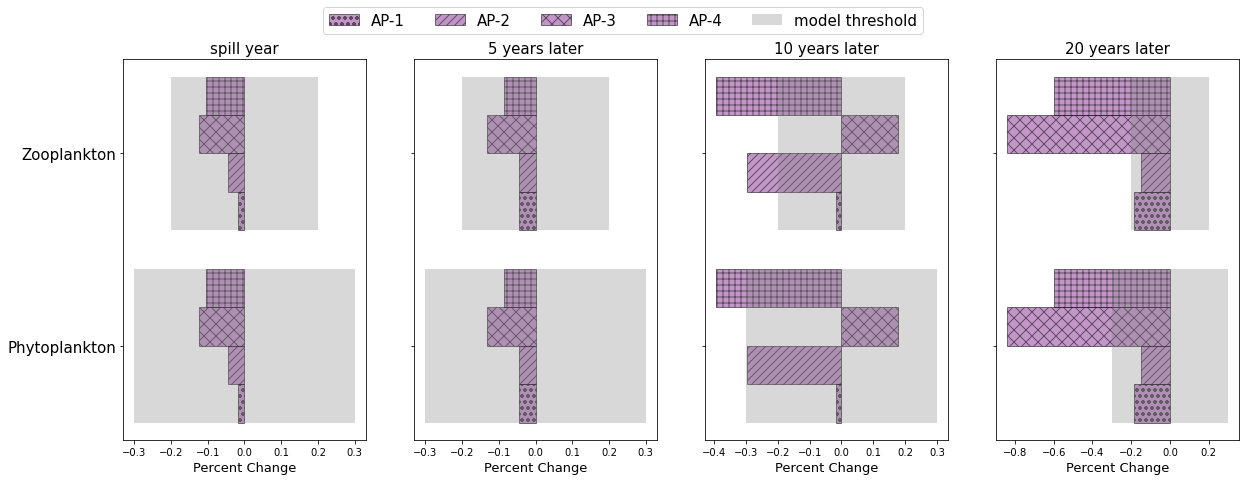

In [31]:
progressive_boxplot_plankton()

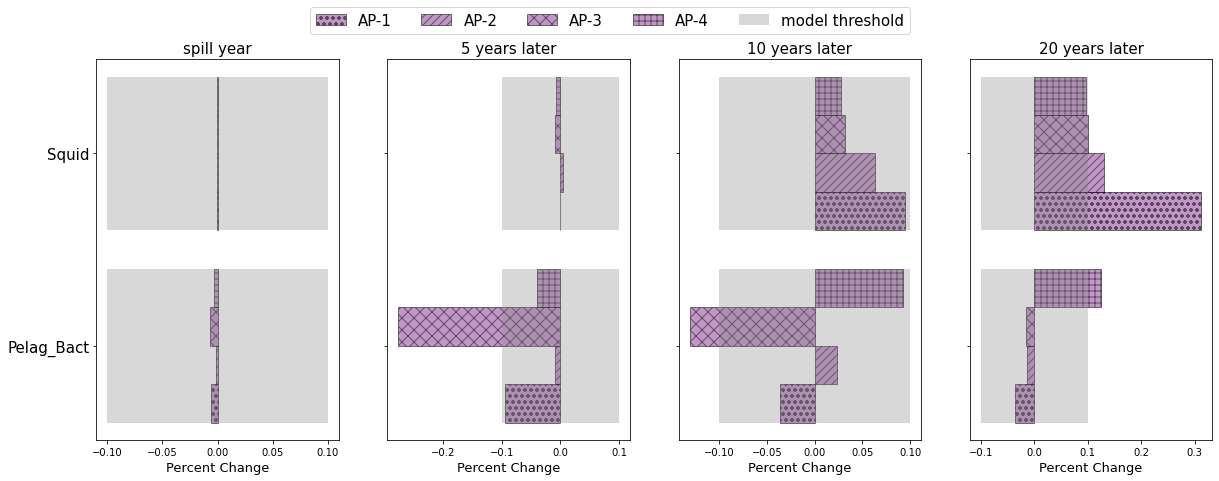

In [33]:
progressive_boxplot_pelagic(groups.other_planktonic)

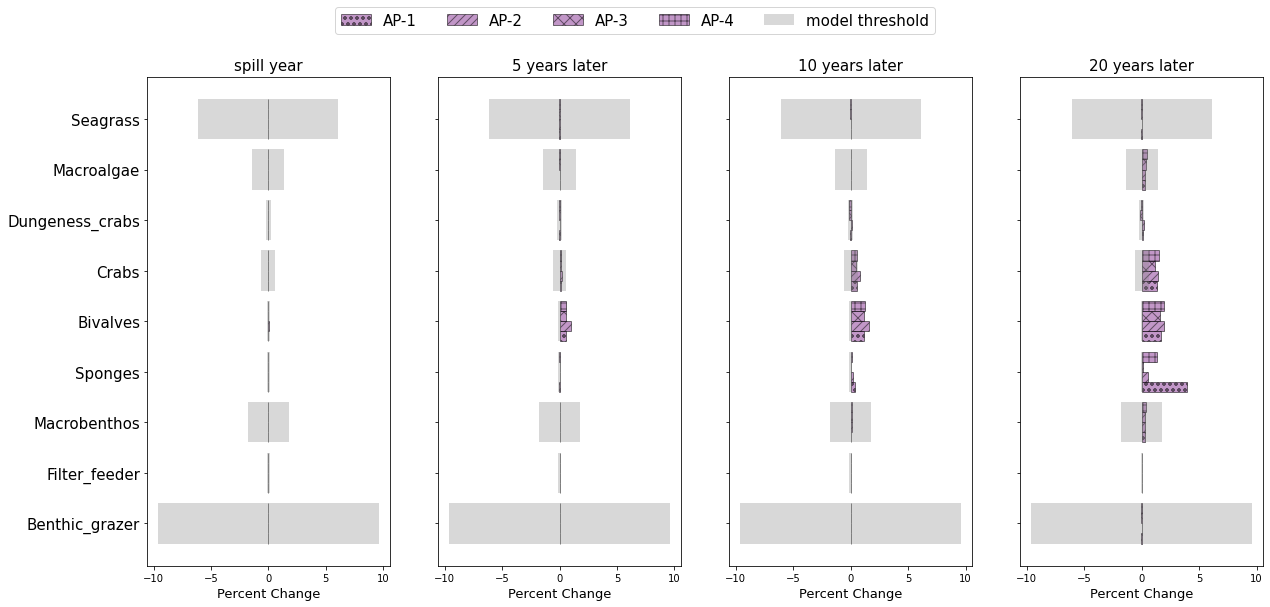

In [34]:
progressive_boxplot_benthic(groups.benthos)

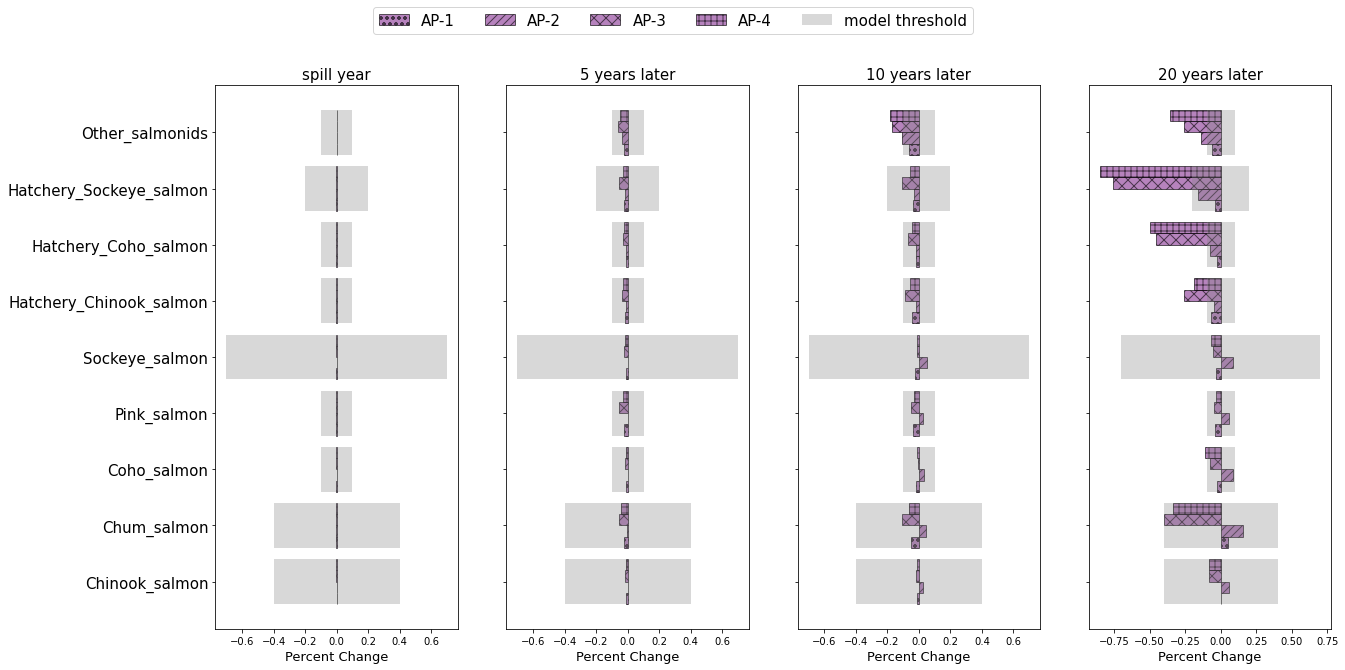

In [35]:
progressive_boxplot_vertebrates(groups.salmon)

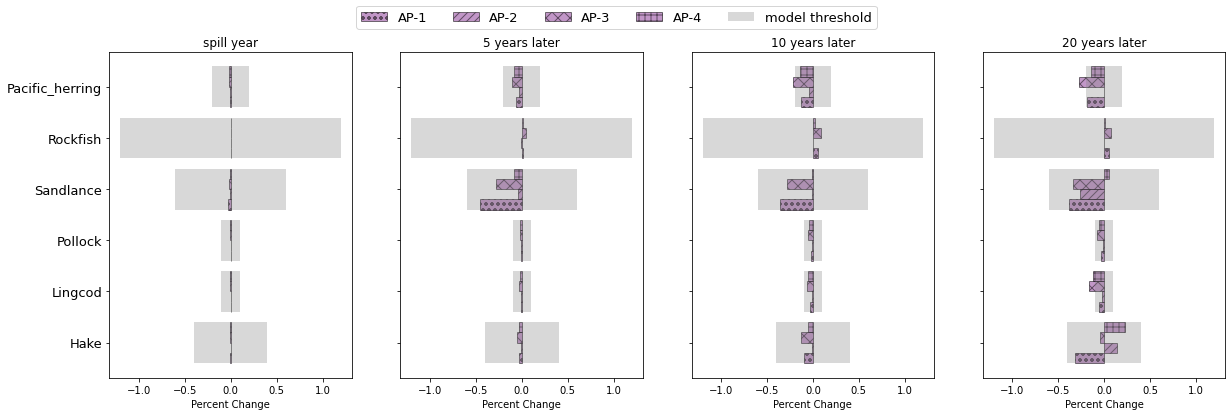

In [20]:
progressive_boxplot_vertebrates(groups.named_fish)

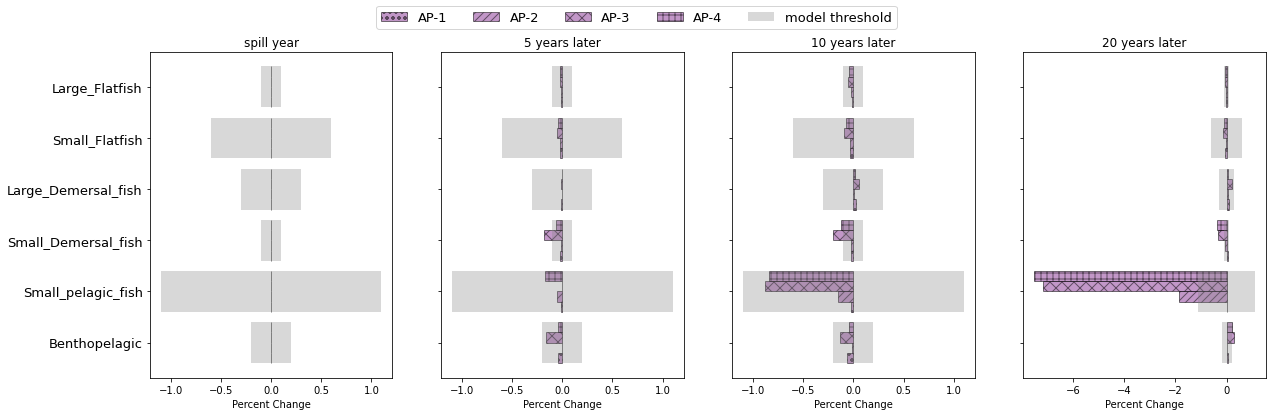

In [21]:
progressive_boxplot_vertebrates(groups.other_fish)

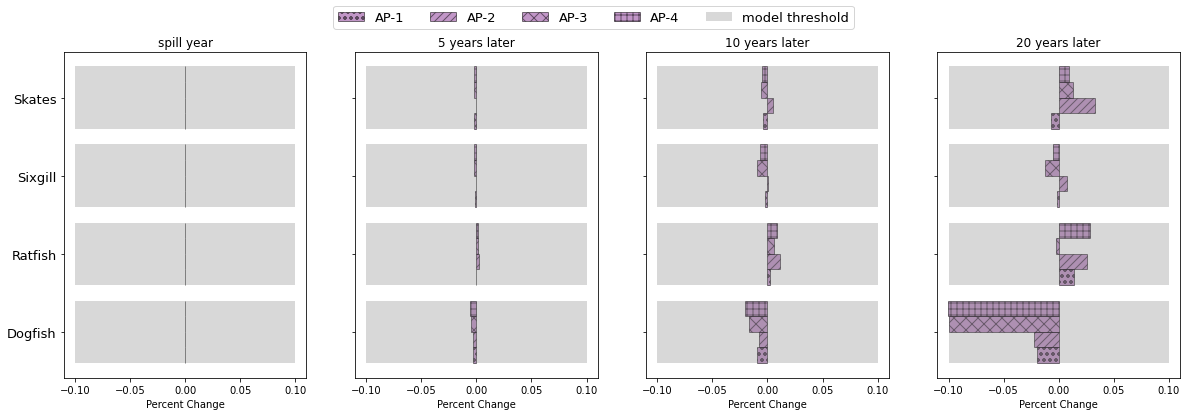

In [22]:
progressive_boxplot_vertebrates(groups.sharks)

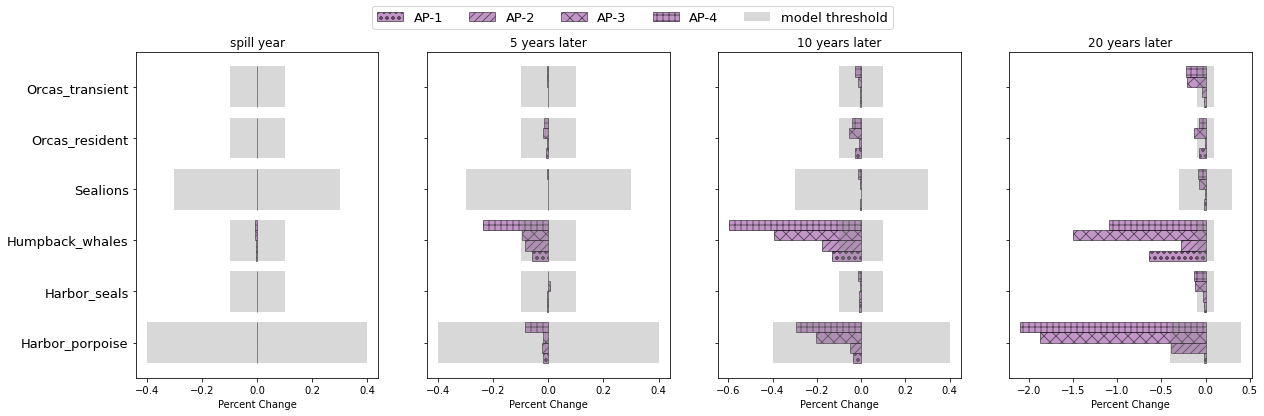

In [23]:
progressive_boxplot_vertebrates(groups.mammals)

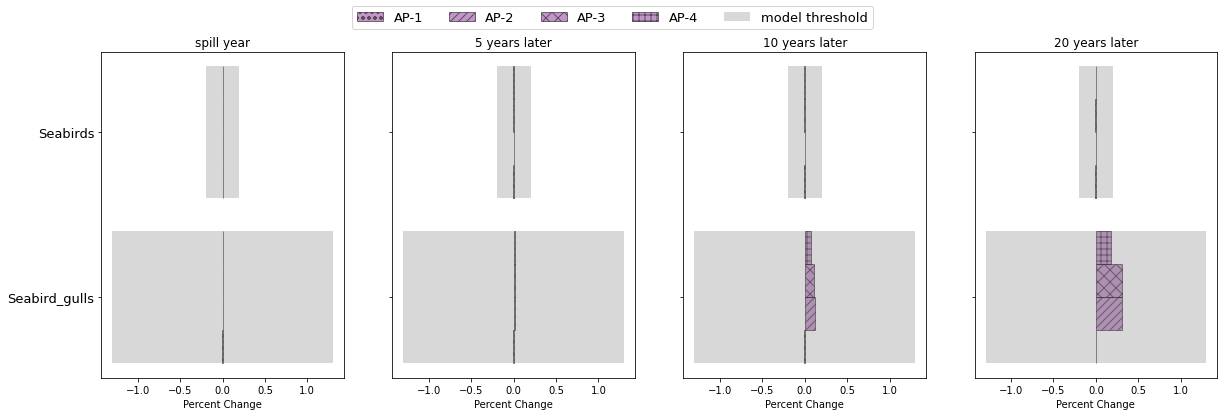

In [24]:
progressive_boxplot_vertebrates(groups.birds)

Long-term abundance change in:
- crabs
- bivalves
- small pelagic fish
- hatchery & other salmon
- humpbacks
- purppoises 

## Regional change

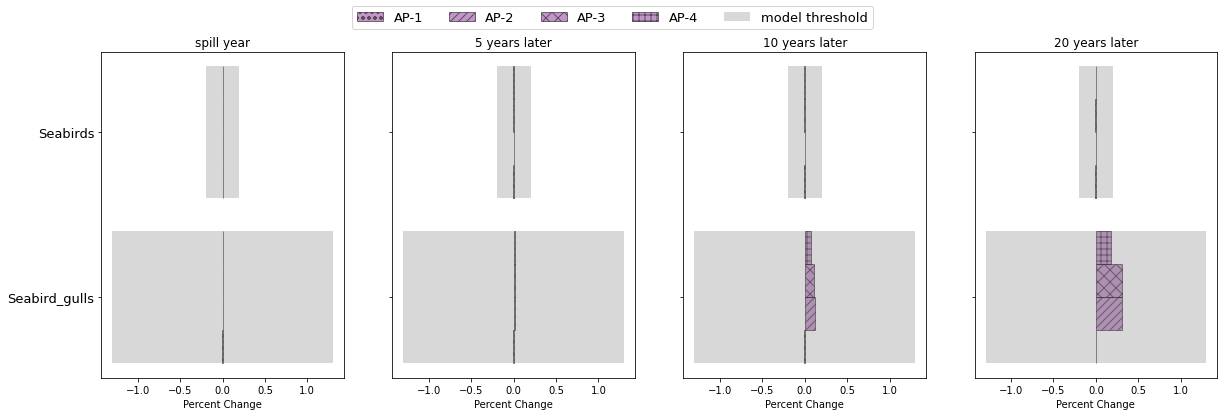

In [14]:
progressive_boxplot_vertebrates(groups.birds, location=affected_boxes)

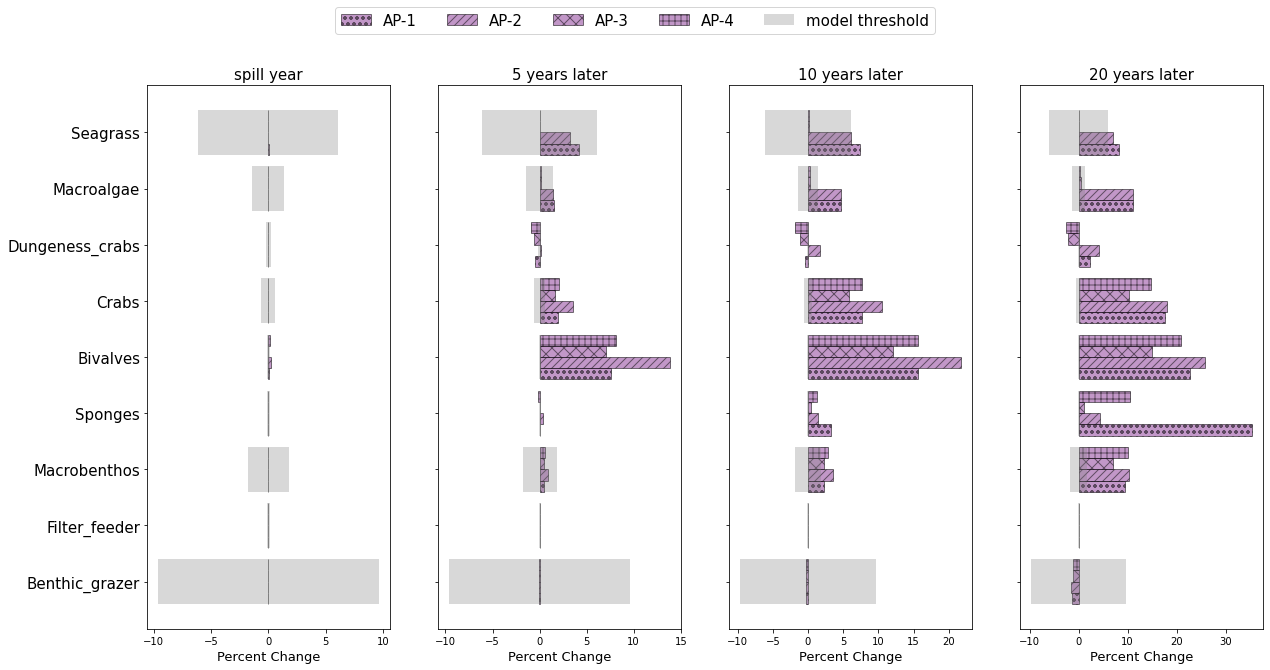

In [97]:
progressive_boxplot_benthic(groups.benthos, location=affected_boxes)

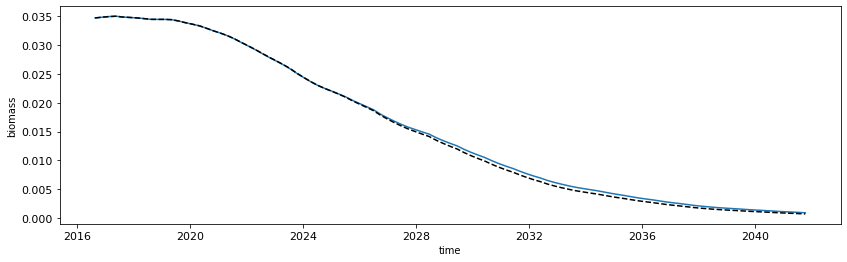

In [39]:
boxes = affected_boxes
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('biomass')
ax.set_xlabel('time')

c_tbl = np.ma.filled(control.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
c_t = c_tbl.sum(axis=(1,2))

o_tbl = np.ma.filled(scenario.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
o_t = o_tbl.sum(axis=(1,2))

ax.plot(time[start:end], o_t, )
ax.plot(time[start:end], c_t, 'k--');

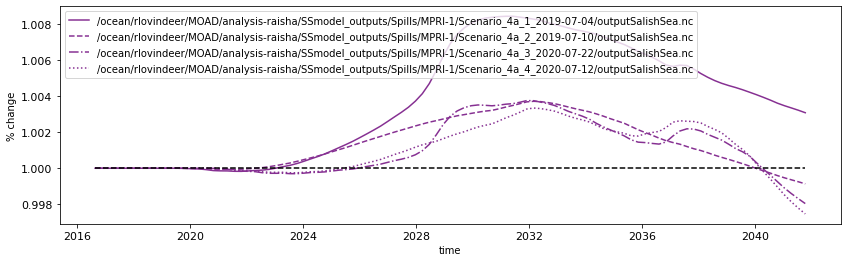

In [52]:
boxes = groups.salish_sea
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% change')
ax.set_xlabel('time')

c_tbl = np.ma.filled(control.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
c_t = c_tbl.sum(axis=(1,2))

for scenario in scenario_datasets:
    o_tbl = np.ma.filled(scenario.variables['Squid_N'][start:end, boxes, 0:6], np.nan)
    o_t = o_tbl.sum(axis=(1,2))

    ax.plot(time[start:end], o_t/c_t, color=hex_colour, linestyle=next(line_styles))
ax.plot(time[start:end], c_t/c_t, 'k--')
ax.legend(scenario_paths);

## Highres

In [53]:
highres_control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
highres_control = xr.open_dataset(str(highres_control_file), decode_cf=True)
highres_time = np.ma.filled(highres_control.variables['t'])

In [54]:
highres_paths = sorted([p for p in scenario_root.glob('highres-scenario_4a*/outputSalishSea.nc')])
highres_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in highres_paths]
for path in highres_paths:
    print(path.parent.stem)

highres-scenario_4a_1_2019-07-04
highres-scenario_4a_2_2019-07-10
highres-scenario_4a_3_2020-07-22
highres-scenario_4a_4_2020-07-12


In [78]:
def plot_aggregate_N(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    names = ['control']
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(control.t, control_ratio, 'k', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  

        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(scenario.t, ratio, linewidth = 2, label=scenario_name, color=hex_colour, linestyle=next(line_styles))
    ax.fill_between(scenario.t, -groups.sensitivity[new_name], groups.sensitivity[new_name], color='grey', alpha=0.3, label='Model threshold')
        
    ax.set_ylabel('Percent (%) change', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1))

In [90]:
def plot_groups_pelagic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 1, wspace=0.2, hspace=0.2, height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        ax = fig.add_subplot(gs[bio_index])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [94]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [104]:
def plot_aggregate_biomass(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    ax.plot(control.t, pelagic_control, 'k--', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  
        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ax.plot(scenario.t, pelagic_oiled, label=scenario_name, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
    ax.set_ylabel('Biomass', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(fontsize=12); #bbox_to_anchor=(1.05, 1)

In [81]:
def plot_aggregate_biomass_change(bio_group, new_name, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig, ax = plt.subplots(figsize = (14,4))
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
    
    pelagic_control = 0
    for species in bio_group:
        pelagic_control = pelagic_control + np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=(1,2))
    ax.plot(control.t, pelagic_control-pelagic_control[0], 'k--', label='control', linewidth = 2)

    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        scenario_name = 'AP-'+nm[2]  
        pelagic_oiled = 0
        
        for species in bio_group:
            pelagic_oiled = pelagic_oiled + np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=(1,2))
        ax.plot(scenario.t, pelagic_oiled-pelagic_oiled[0], label=scenario_name, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
    ax.set_ylabel('Biomass relative to initial', fontsize=12)
    ax.set_title(new_name)
    ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [87]:
def plot_pelagic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 1, wspace=0.2, hspace=0.2, height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        ax = fig.add_subplot(gs[bio_index])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [93]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'TP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

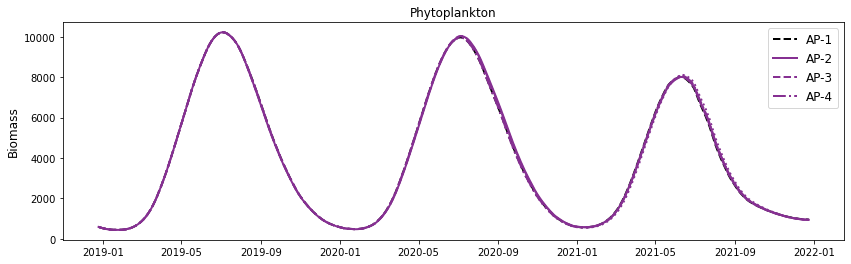

In [101]:
plot_aggregate_biomass(groups.phytoplankton, 'Phytoplankton', highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

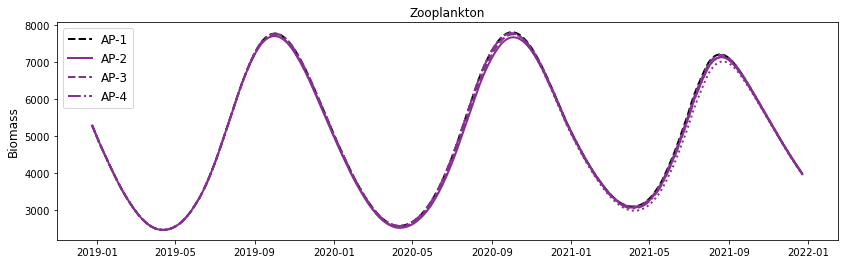

In [100]:
plot_aggregate_biomass(groups.zooplankton, 'Zooplankton', highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

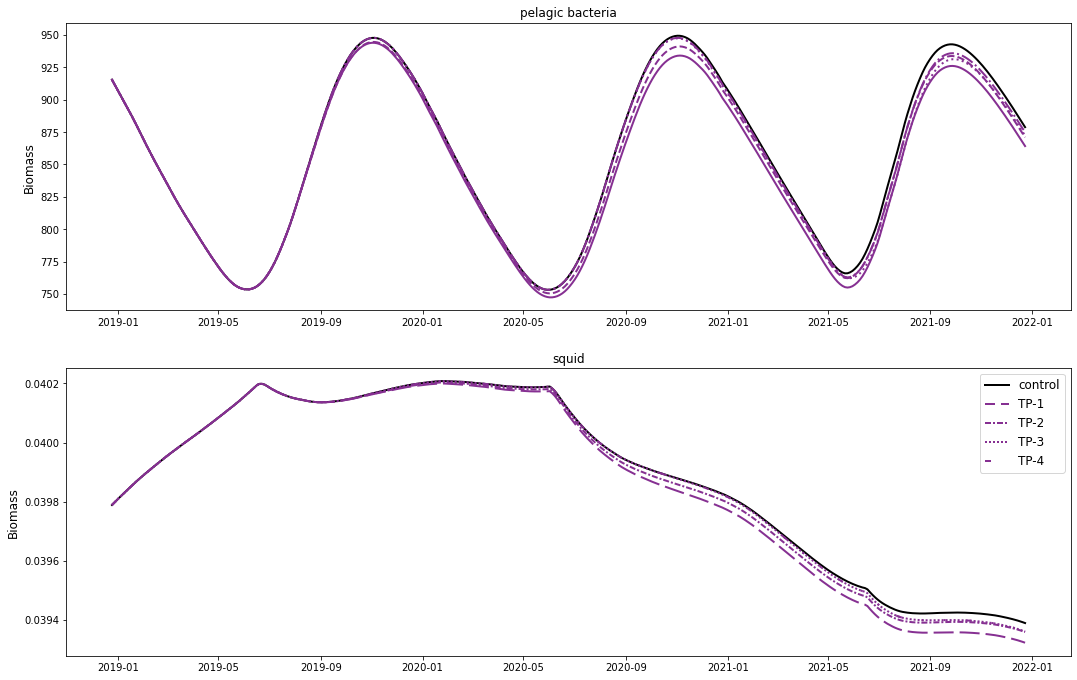

In [99]:
plot_pelagic_biomass(groups.other_planktonic, highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

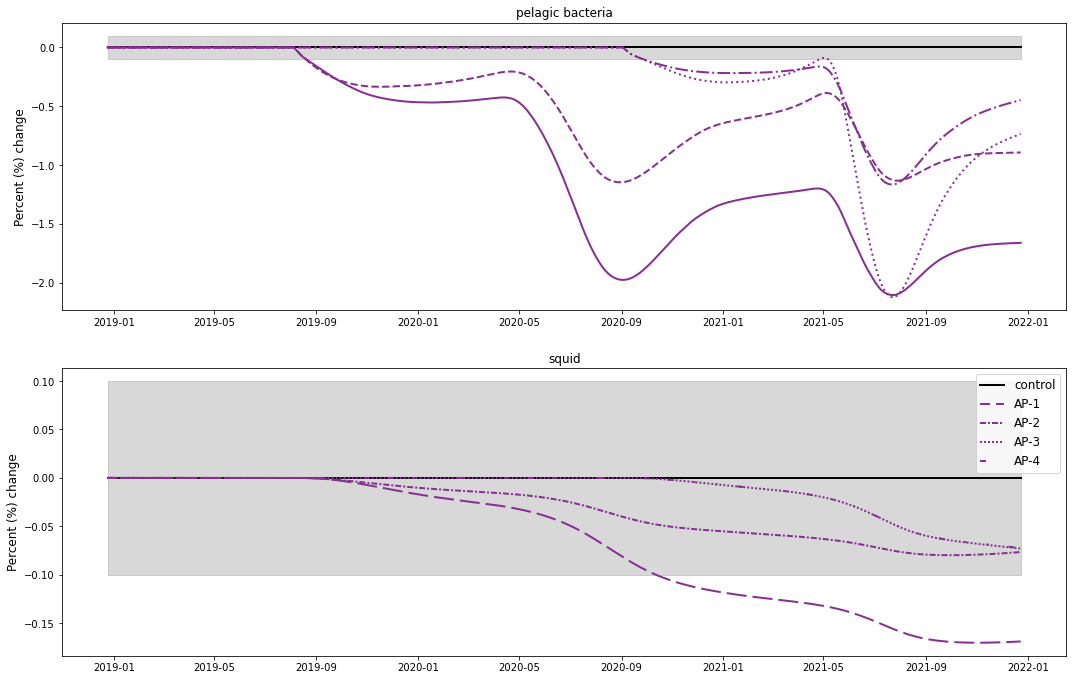

In [92]:
plot_groups_pelagic_N(groups.other_planktonic, highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

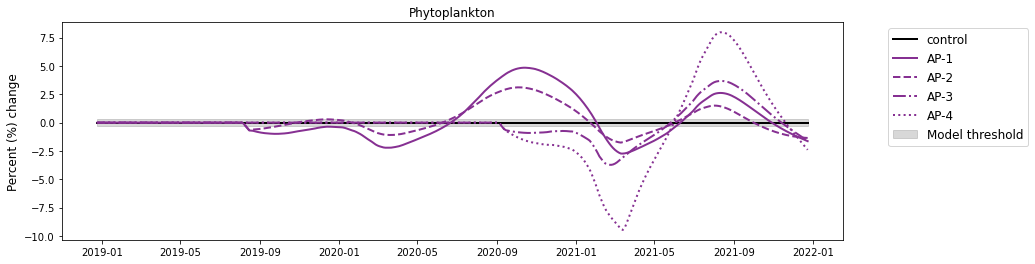

In [79]:
plot_aggregate_N(groups.phytoplankton, 'Phytoplankton', highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

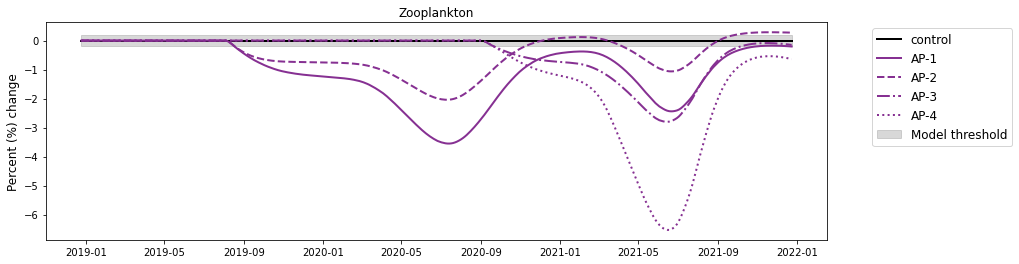

In [80]:
plot_aggregate_N(groups.zooplankton, 'Zooplankton', highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

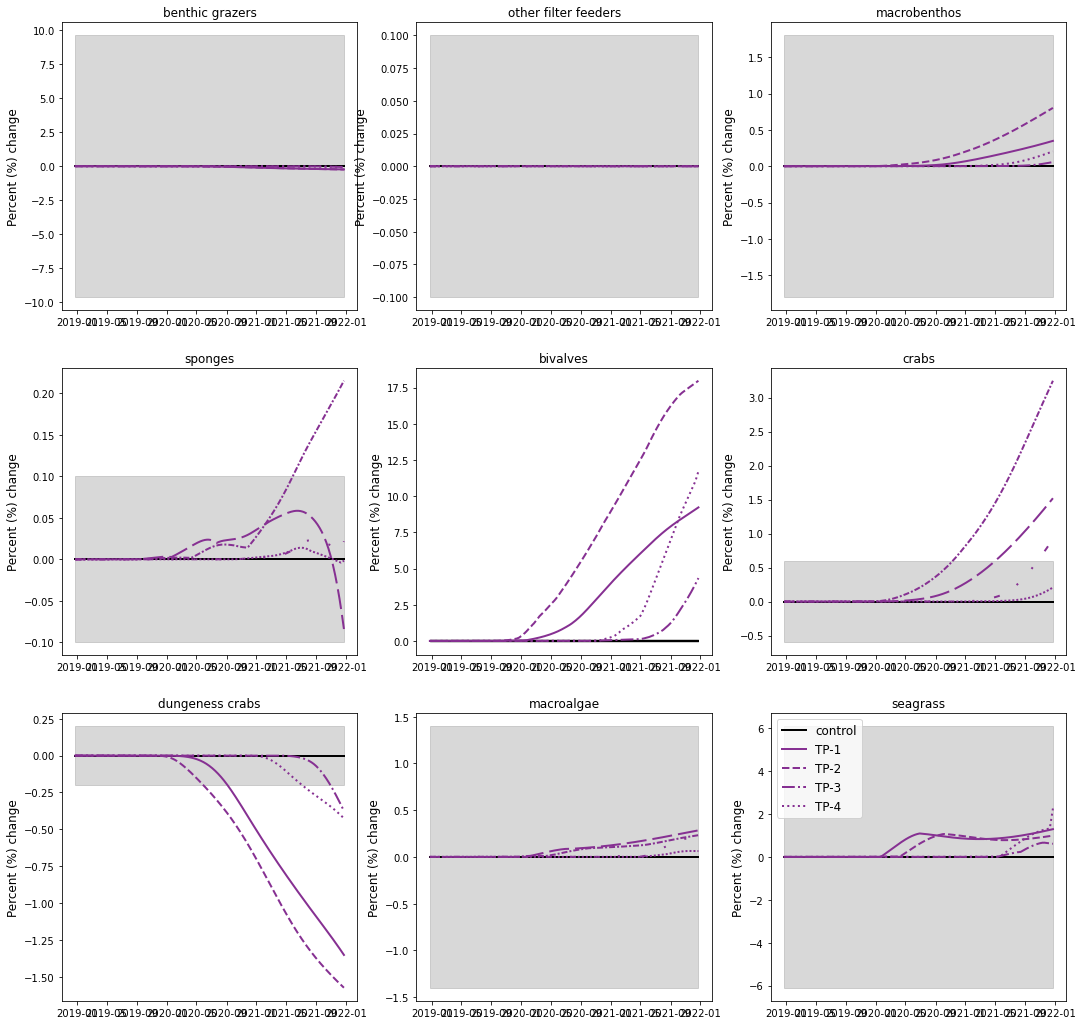

In [95]:
plot_groups_benthic_N(groups.benthos, highres_datasets, highres_paths, control=highres_control, boxes=affected_boxes)

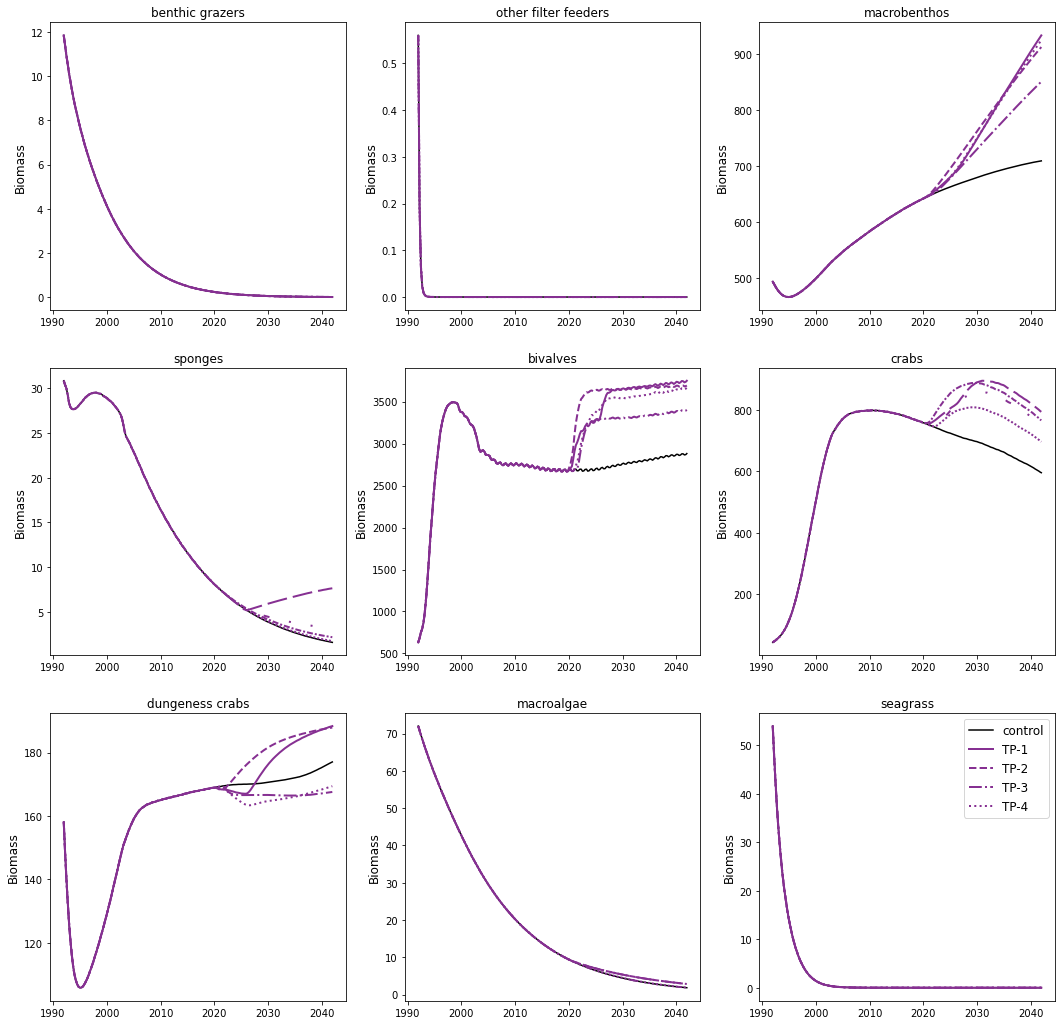

In [14]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)

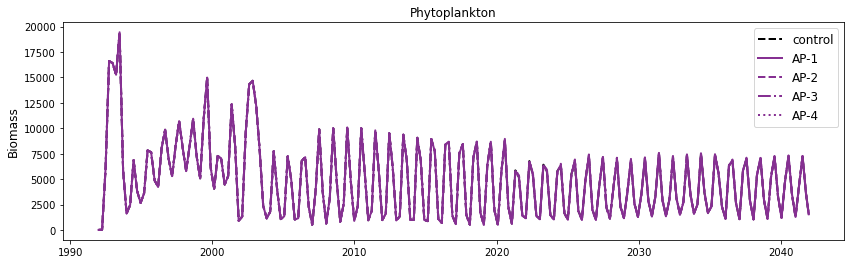

In [105]:
plot_aggregate_biomass(groups.phytoplankton, 'Phytoplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

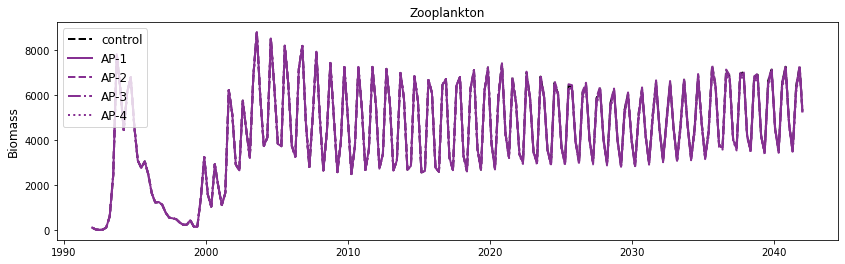

In [106]:
plot_aggregate_biomass(groups.zooplankton, 'Zooplankton', scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)